In [17]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import sweetviz as sv
import dtale
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from pprint import pprint
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from pandas.plotting import andrews_curves
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as sps
import matplotlib.patches as mpatches
red_wine=pd.read_csv("winequality-red.csv",sep=";")
white_wine=pd.read_csv("winequality-white.csv",sep=";")
#Column renaming according to usual conventions
red_wine.columns=red_wine.columns.str.replace(" ","_")
white_wine.columns=white_wine.columns.str.replace(" ","_")
#Categorization of quality into three groups
red_wine["quality_label"] = red_wine["quality"].apply(lambda value: 0 if value<=5 else 1 if value< 7 else 2)
white_wine["quality_label"]=white_wine["quality"].apply(lambda value: 0 if value<=5 else 1 if value< 7 else 2)
red_wine["quality_label"]=pd.Categorical(red_wine["quality_label"],categories=[0,1,2])
white_wine["quality_label"]=pd.Categorical(white_wine["quality_label"],categories=[0,1,2])
#Combining the two wine databases
wines=pd.concat([red_wine,white_wine])
wines=wines.sample(frac=1,random_state=42).reset_index(drop=True)

In [31]:
x=white_wine.drop(["quality","quality_label"],axis=1)
y=white_wine["quality"]
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42)
xtrain_norm=xtrain
xtest_norm=xtest

In [32]:
#Data is normalised since distribution for all except pH is skewed
#Normalisation only has a noticeable impact in non RF methods
#If not normalised, the accuracy is less than 50%. With normalisation it it around 57%.
norm=MinMaxScaler()
norm_fit=norm.fit(xtrain)
xtrain_norm=norm_fit.transform(xtrain)
xtest_norm=norm_fit.transform(xtest)

In [20]:
n_estimators=[int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_features=["auto","sqrt"]
max_depth=[int(x) for x in np.linspace(10,110,num=11)]
max_depth.append(None)
min_samples_split=[2,5,10]
min_samples_leaf=[1,2,4]
bootstrap=[True,False]
grid={"n_estimators":n_estimators,"max_features":max_features,"max_depth":max_depth,
"min_samples_split":min_samples_split,"min_samples_leaf":min_samples_leaf,"bootstrap":bootstrap}
rf=RandomForestRegressor()
random_grid=RandomizedSearchCV(estimator=rf,param_distributions=grid,n_iter=100,cv=3,verbose=2,random_state=42,n_jobs=-1)
random_grid.fit(xtrain,ytrain)
print(random_grid.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}


In [29]:
best_grid={"bootstrap":[False],"max_depth":[None],"max_features":[2,3],"min_samples_leaf":[1,2,3],"min_samples_split":[2,4,6],"n_estimators":[200,400,600,800,1000,1600]}
rf=RandomForestRegressor()
grid_search=GridSearchCV(estimator=rf,param_grid=best_grid,cv=3,n_jobs=-1,verbose=2)
grid_search.fit(xtrain_norm,ytrain)
print(grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'bootstrap': False, 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [33]:
#Deafault accuracy is ~69%
#With hyperparameter tuning we can go up to 71%, by setting the n_estimators to 1000 and bootstrap=False; the rest are default
rf=RandomForestClassifier(n_estimators=1000,max_features=2,bootstrap=False)
rf_fit=rf.fit(xtrain_norm,ytrain)
pred_rf=rf.predict(xtest_norm)
rf=accuracy_score(ytest,pred_rf)
print(rf)
print(classification_report(ytest,pred_rf))

0.7081632653061225
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.67      0.32      0.43        25
           5       0.74      0.70      0.72       291
           6       0.67      0.81      0.73       432
           7       0.76      0.61      0.68       192
           8       0.89      0.46      0.60        35

    accuracy                           0.71       980
   macro avg       0.62      0.48      0.53       980
weighted avg       0.71      0.71      0.70       980



In [23]:
#Accuracy is ~55%
lr=LogisticRegression()
lr.fit(xtrain_norm,ytrain)
pred_lr=lr.predict(xtest_norm)
lr=accuracy_score(ytest,pred_lr)
print(classification_report(ytest,pred_lr))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        25
           5       0.57      0.51      0.54       291
           6       0.50      0.77      0.61       432
           7       0.50      0.14      0.22       192
           8       0.00      0.00      0.00        35

    accuracy                           0.52       980
   macro avg       0.26      0.24      0.23       980
weighted avg       0.49      0.52      0.47       980



In [24]:
#Accuracy is ~57%
svc=SVC()
svc.fit(xtrain_norm,ytrain)
pred_svc=svc.predict(xtest_norm)
svc=accuracy_score(ytest,pred_svc)
print(classification_report(ytest,pred_svc))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       1.00      0.04      0.08        25
           5       0.63      0.55      0.59       291
           6       0.51      0.78      0.62       432
           7       0.57      0.19      0.28       192
           8       0.00      0.00      0.00        35

    accuracy                           0.55       980
   macro avg       0.45      0.26      0.26       980
weighted avg       0.55      0.55      0.50       980



In [25]:
#Accuracy is ~58%
knn=KNeighborsClassifier(n_neighbors=10,leaf_size=20)
knn.fit(xtrain_norm,ytrain)
pred_knn=knn.predict(xtest_norm)
knn=accuracy_score(ytest,pred_knn)
print(classification_report(ytest,pred_knn))

              precision    recall  f1-score   support

           3       1.00      0.20      0.33         5
           4       0.14      0.04      0.06        25
           5       0.55      0.58      0.57       291
           6       0.54      0.64      0.58       432
           7       0.53      0.41      0.46       192
           8       0.50      0.09      0.15        35

    accuracy                           0.54       980
   macro avg       0.54      0.33      0.36       980
weighted avg       0.53      0.54      0.52       980



<AxesSubplot:xlabel='Accuracy', ylabel='Ensemble'>

findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


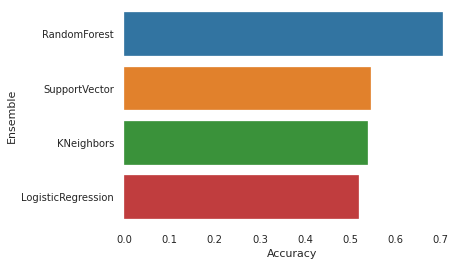

In [26]:
%matplotlib inline
mods=pd.DataFrame({"Ensemble":["RandomForest","LogisticRegression","SupportVector","KNeighbors"],"Accuracy":[rf,lr,svc,knn]})
mods.sort_values(by="Accuracy",ascending=False,inplace=True)
a=sns.barplot(x="Accuracy",y="Ensemble",data=mods)
a